<a href="https://colab.research.google.com/github/micheldc55/Deep-Learning/blob/main/sentiment_analysis_airline_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 16.6 MB/s 
     |████████████████████████████████| 7.6 MB 54.1 MB/s 
     |████████████████████████████████| 182 kB 50.0 MB/s 


In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2022-11-26 20:27:07--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M   281KB/s    in 15s     

2022-11-26 20:27:23 (219 KB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [ ]:
from transformers import pipeline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

## Instanciating the pipeline object for Sentiment Analysis

In [ ]:
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

## Going over some examples

### Simple one-liners

In [ ]:
classifier('This is a very good movie')

[{'label': 'POSITIVE', 'score': 0.9998689889907837}]

In [ ]:
classifier('This show was not interesting')

[{'label': 'NEGATIVE', 'score': 0.9997871518135071}]

In [ ]:
classifier('This show was interesting')

[{'label': 'POSITIVE', 'score': 0.999747097492218}]

In [ ]:
classifier('This show was not bad at all')

[{'label': 'POSITIVE', 'score': 0.998742401599884}]

In [ ]:
classifier("I can't say that this was a good movie")

[{'label': 'NEGATIVE', 'score': 0.9278427958488464}]

### Multiple Inputs

In [ ]:
classifier([
    'This is just what I need',
    "I can't understand any of this. The instructor keeps telling me to meet the prerequisites. What are prerequisites? Why do I need them?"
])

[{'label': 'POSITIVE', 'score': 0.9994087219238281},
 {'label': 'NEGATIVE', 'score': 0.9905425906181335}]

## Using the classifier on the GPU to make inference faster

In [ ]:
import torch

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.current_device()

0

In [ ]:
classifier = pipeline('sentiment-analysis', device=0)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
base_df = pd.read_csv('AirlineTweets.csv')

In [ ]:
base_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


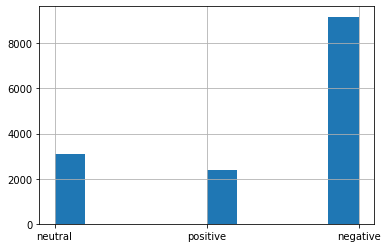

In [ ]:
base_df['airline_sentiment'].hist()

In [ ]:
df = base_df[base_df['airline_sentiment'] != 'neutral']

In [ ]:
df['target'] = df['airline_sentiment'].map(lambda x: 1 if x.lower() == 'positive' else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,target
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),1
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),0
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),0
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),1


In [ ]:
len(df)

11541

In [ ]:
texts = df['text'].tolist()
preds = classifier(texts)

In [ ]:
preds

In [ ]:
probabilities = [pred['score'] if pred['label'] == 'POSITIVE' else 1 - pred['score'] for pred in preds]
preds = [1 if pred['label'] == 'POSITIVE' else 0 for pred in preds]

In [ ]:
preds = np.array(preds)
preds

array([1, 0, 0, ..., 1, 0, 0])

In [ ]:
print('accuracy:', np.mean(df['target'] == preds))

accuracy: 0.8898708950697514


In [ ]:
y_true = df['target']

In [ ]:
cm = confusion_matrix(y_true, preds, normalize='true')
cm

array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])